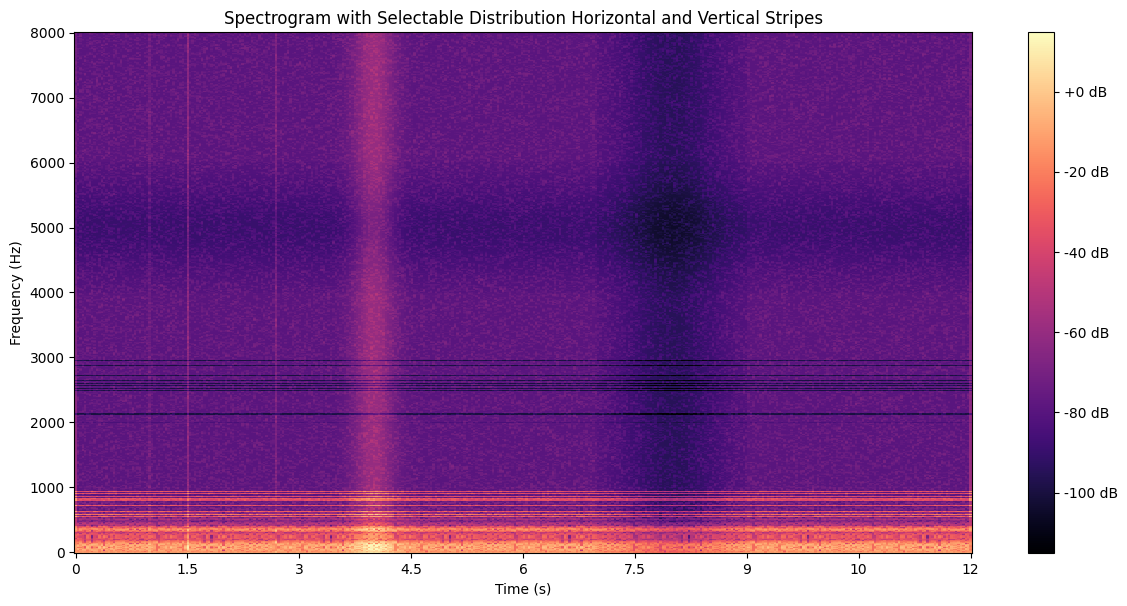

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

def _generate_perlin_noise(length, params):
    # Perlin 노이즈 생성을 위한 함수
    # 참고: Perlin 노이즈는 연속적이고 스무스한 노이즈를 생성하는 알고리즘.
    # 여기서는 간단히 1차원 Perlin 노이즈를 구현한다.
    # 옥타브 수, 주파수, 정규화 여부 등을 파라미터로 제어할 수 있다.
    # 기본 구현: 옥타브 1개, 길이만큼 Perlin 노이즈 생성
    # 복잡한 Perlin 구현 대신 간략한 1D Perlin 노이즈 생성 알고리즘 사용.
    def fade(t):
        return 6*t**5 - 15*t**4 + 10*t**3

    def grad(hash_val, x):
        # 단순 gradient hash
        return (hash_val & 1)*2-1 * x

    seed = params.get('seed', 0)
    np.random.seed(seed)
    # Perlin 노이즈를 위해 pseudo random permutation table 생성
    perm = np.arange(256)
    np.random.shuffle(perm)
    perm = np.stack([perm, perm]).flatten()

    scale = params.get('scale', 50.0)
    xs = np.linspace(0, length/scale, length)
    xi = np.floor(xs).astype(int)
    xf = xs - xi
    xi = xi % 256

    # 좌우 gradient 선택
    left_hash = perm[xi]
    right_hash = perm[xi+1]

    # fade 함수 적용
    u = fade(xf)

    # gradient 계산
    left_grad = (left_hash & 1)*2-1
    right_grad = (right_hash & 1)*2-1

    # lerp
    noise = (1-u)*left_grad*xf + u*right_grad*(xf-1)
    # 정규화
    noise = noise / np.max(np.abs(noise))
    return noise

def _generate_brownian_noise(length, params):
    # Brownian(브라운) 노이즈 = 적분된 백색잡음
    # 가우시안 노이즈를 누적합하여 생성
    mean = params.get('mean', 0.0)
    std = params.get('std', 1.0)
    white_noise = np.random.normal(mean, std, length)
    # 누적합으로 Brownian motion
    brown = np.cumsum(white_noise)
    brown = brown / np.max(np.abs(brown))
    return brown

def _generate_salt_and_pepper_noise(length, params):
    # Salt-and-Pepper 노이즈: 일정 비율로 최소값/최대값을 랜덤하게 배치
    # ratio: 소금, 후추 잡음이 삽입되는 비율
    ratio = params.get('ratio', 0.05)
    min_val = params.get('min_val', -1.0)
    max_val = params.get('max_val', 1.0)

    noise = np.zeros(length)
    num_sp = int(length * ratio)
    # 무작위 인덱스 선택
    sp_indices = np.random.choice(np.arange(length), size=num_sp, replace=False)
    half = num_sp // 2
    # 절반은 salt(max_val), 절반은 pepper(min_val)
    noise[sp_indices[:half]] = max_val
    noise[sp_indices[half:]] = min_val
    return noise

def _generate_linear_noise(length, params):
    # Linear 노이즈: low에서 high까지 선형 증가하는 노이즈
    low = params.get('low', -1.0)
    high = params.get('high', 1.0)
    return np.linspace(low, high, length)

class SpectrogramModifier:
    def __init__(self, sample_rate=16000, n_fft=256, hop_length=None, 
                 noise_strength=0.1, noise_type='gaussian', noise_params=None):
        """스펙트로그램 생성 및 패턴 추가 클래스"""
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length if hop_length is not None else n_fft // 4
        self.noise_strength = noise_strength
        self.noise_type = noise_type
        self.noise_params = noise_params if noise_params else {}
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None

    def _generate_gaussian_noise(self, length, params):
        mean = params.get('mean', 0.0)
        std = params.get('std', 1.0)
        return np.random.normal(mean, std, length)

    def _generate_uniform_noise(self, length, params):
        low = params.get('low', -1.0)
        high = params.get('high', 1.0)
        return np.random.uniform(low, high, length)

    def _generate_poisson_noise(self, length, params):
        lam = params.get('lam', 5)
        return (np.random.poisson(lam, length) - lam) / lam

    def _generate_exponential_noise(self, length, params):
        scale = params.get('scale', 1.0)
        # 지수분포는 양수 편향이므로 평균 조정을 위해 중심화(평균 0 만들기)
        noise = np.random.exponential(scale, length)
        noise -= np.mean(noise)
        noise = noise / np.max(np.abs(noise))
        return noise

    def _generate_cauchy_noise(self, length, params):
        # Cauchy 분포는 np.random.standard_cauchy 사용
        noise = np.random.standard_cauchy(length)
        # 과도한 극값을 잘라내어 스케일링
        noise = np.clip(noise, -10, 10)
        noise = noise / np.max(np.abs(noise))
        return noise

    def _generate_beta_noise(self, length, params):
        a = params.get('a', 2.0)
        b = params.get('b', 2.0)
        # Beta(2,2)는 [0,1] 범위. -1~1 범위로 매핑
        noise = np.random.beta(a, b, length)
        noise = (noise - 0.5) * 2.0
        return noise

    def generate_noise(self, signal):
        """선택된 노이즈 타입으로 신호에 노이즈 추가"""
        length = len(signal)
        nt = self.noise_type
        p = self.noise_params
        if nt == 'gaussian':
            noise = self._generate_gaussian_noise(length, p)
        elif nt == 'linear':
            noise = _generate_linear_noise(length, p)
        elif nt == 'poisson':
            noise = self._generate_poisson_noise(length, p)
        elif nt == 'uniform':
            noise = self._generate_uniform_noise(length, p)
        elif nt == 'salt-and-pepper':
            noise = _generate_salt_and_pepper_noise(length, p)
        elif nt == 'perlin':
            noise = _generate_perlin_noise(length, p)
        elif nt == 'brownian':
            noise = _generate_brownian_noise(length, p)
        elif nt == 'exponential':
            noise = self._generate_exponential_noise(length, p)
        elif nt == 'cauchy':
            noise = self._generate_cauchy_noise(length, p)
        elif nt == 'beta':
            noise = self._generate_beta_noise(length, p)
        else:
            noise = np.zeros_like(signal)
        return signal + noise * self.noise_strength

    def compute_spectrogram(self, signal):
        """입력 신호의 dB 스펙트로그램 계산"""
        self.signal = signal
        self.signal_with_noise = self.generate_noise(signal)
        S = np.abs(librosa.stft(self.signal_with_noise, n_fft=self.n_fft, hop_length=self.hop_length, window='hann'))
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def _get_freqs(self):
        return np.linspace(0, self.sample_rate / 2, self.S_db.shape[0])

    def _get_times(self):
        return librosa.frames_to_time(np.arange(self.S_db.shape[1]), sr=self.sample_rate, hop_length=self.hop_length)

    def _get_distribution(self, values, distribution, params):
        if distribution == 'gaussian':
            sigma = params.get('sigma', 5)
            center = (values.min() + values.max()) / 2
            dist = np.exp(-0.5 * ((values - center) / sigma) ** 2)
        elif distribution == 'uniform':
            dist = np.ones_like(values)
        elif distribution == 'exponential':
            scale = params.get('scale', 1.0)
            dist = np.exp(-values / scale)
        else:
            sigma = params.get('sigma', 5)
            center = (values.min() + values.max()) / 2
            dist = np.exp(-0.5 * ((values - center) / sigma) ** 2)
        dist /= dist.max()
        return dist

    def add_horizontal_stripe_pattern_dB(self, stripe_freqs, intensity_factor=1.0):
        """지정 주파수에서 dB 패턴 추가"""
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        S_db_modified = self.S_db.copy()
        freqs = self._get_freqs()
        for stripe in stripe_freqs:
            freq = stripe['freq']
            strength_dB = stripe['strength_dB'] * intensity_factor
            freq_idx = np.argmin(np.abs(freqs - freq))
            S_db_modified[freq_idx, :] += strength_dB
        self.S_db = S_db_modified
        return self.S_db

    def add_horizontal_energy_distribution_range_dB(self, stripe_freq_ranges, intensity_factor=1.0):
        """주파수 구간에 분포 기반 dB 패턴 추가"""
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        S_db_modified = self.S_db.copy()
        freqs = self._get_freqs()
        for stripe in stripe_freq_ranges:
            freq_min = stripe['freq_min']
            freq_max = stripe['freq_max']
            strength_dB = stripe['strength_dB'] * intensity_factor
            distribution = stripe.get('distribution', 'gaussian')
            distribution_params = stripe.get('distribution_params', {})
            freq_indices = np.where((freqs >= freq_min) & (freqs <= freq_max))[0]
            if len(freq_indices) == 0:
                continue
            dist_values = freqs[freq_indices]
            energy_distribution = self._get_distribution(dist_values, distribution, distribution_params)
            S_db_modified[freq_indices, :] += strength_dB * energy_distribution[:, np.newaxis]
        self.S_db = S_db_modified
        return self.S_db

    def add_random_horizontal_stripes_within_range_dB(self, freq_min, freq_max, strength_dB, n, mode='random'):
        """주파수 구간 내에 n개 랜덤/선형 주파수 지점에 dB 패턴 추가"""
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        S_db_modified = self.S_db.copy()
        freqs = self._get_freqs()
        available_freqs = np.where((freqs >= freq_min) & (freqs <= freq_max))[0]
        if len(available_freqs) == 0:
            return S_db_modified
        if mode == 'linear':
            selected_indices = np.linspace(available_freqs.min(), available_freqs.max(), num=n, dtype=int)
            selected_indices = selected_indices[selected_indices < len(freqs)]
        else:
            if n > len(available_freqs):
                n = len(available_freqs)
            selected_indices = np.random.choice(available_freqs, size=n, replace=False)
        for freq_idx in selected_indices:
            S_db_modified[freq_idx, :] += strength_dB
        self.S_db = S_db_modified
        return self.S_db

    def add_vertical_stripe_pattern_dB(self, stripe_times, intensity_factor=1.0):
        """지정 시간 지점에 dB 패턴 추가"""
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        S_db_modified = self.S_db.copy()
        times = self._get_times()
        for stripe in stripe_times:
            time = stripe['time']
            strength_dB = stripe['strength_dB'] * intensity_factor
            time_idx = np.argmin(np.abs(times - time))
            S_db_modified[:, time_idx] += strength_dB
        self.S_db = S_db_modified
        return self.S_db

    def add_vertical_energy_distribution_range_dB(self, stripe_time_ranges, intensity_factor=1.0):
        """시간 구간에 분포 기반 dB 패턴 추가"""
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        S_db_modified = self.S_db.copy()
        times = self._get_times()
        for stripe in stripe_time_ranges:
            time_min = stripe['time_min']
            time_max = stripe['time_max']
            strength_dB = stripe['strength_dB'] * intensity_factor
            distribution = stripe.get('distribution', 'gaussian')
            distribution_params = stripe.get('distribution_params', {})
            time_indices = np.where((times >= time_min) & (times <= time_max))[0]
            if len(time_indices) == 0:
                continue
            dist_values = times[time_indices]
            energy_distribution = self._get_distribution(dist_values, distribution, distribution_params)
            S_db_modified[:, time_indices] += strength_dB * energy_distribution[np.newaxis, :]
        self.S_db = S_db_modified
        return self.S_db

    def scale_spectrogram(self, scaling_factor=1.0):
        """전체 스펙트로그램 dB 스케일 조정"""
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        self.S_db = self.S_db * scaling_factor
        return self.S_db

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram'):
        """스펙트로그램 시각화"""
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0.5)
        return fig, ax

# 사용 예시
sample_rate = 16000
duration = 12
n_samples = sample_rate * duration
np.random.seed(42)
signal = np.random.normal(-80, 1, n_samples) # base gaussian

# noise_type, noise_params를 원하는 대로 변경 가능
spectro_mod = SpectrogramModifier(
    sample_rate=sample_rate, 
    n_fft=1024, 
    hop_length=512, 
    noise_strength=600, 
    noise_type='perlin', # 절반 정도의 다른 분포를 섞어줌
    noise_params={'seed': 42, 'scale': 100.0}
)
S_db = spectro_mod.compute_spectrogram(signal)

stripe_freqs = [
    {'freq': 500, 'strength_dB': 5},
    {'freq': 1000, 'strength_dB': 2},
    {'freq': 2000, 'strength_dB': -5}
]

stripe_freq_ranges = [
    {'freq_min': 300, 'freq_max': 400, 'strength_dB': 30, 'distribution': 'gaussian', 'distribution_params': {'sigma': 50}},
    {'freq_min': 4000, 'freq_max': 6000, 'strength_dB': -10, 'distribution': 'gaussian', 'distribution_params': {'sigma': 500}}
]

stripe_random_freq_ranges = [
    {'freq_min': 500, 'freq_max': 1000, 'strength_dB': 40, 'n': 10, 'mode': 'random'},
    {'freq_min': 2000, 'freq_max': 3000, 'strength_dB': -20, 'n': 10, 'mode': 'random'}
]

stripe_times = [
    {'time': 1, 'strength_dB': 5},
    {'time': 2.7, 'strength_dB': 10},
    {'time': 1.5, 'strength_dB': 15}
]

stripe_time_ranges = [
    {'time_min': 3, 'time_max': 5, 'strength_dB': 20, 'distribution': 'gaussian', 'distribution_params': {'sigma': 0.2}},
    {'time_min': 7, 'time_max': 9, 'strength_dB': -15, 'distribution': 'gaussian', 'distribution_params': {'sigma': 0.5}}
]

spectro_mod.add_horizontal_stripe_pattern_dB(stripe_freqs)
spectro_mod.add_horizontal_energy_distribution_range_dB(stripe_freq_ranges)
for stripe in stripe_random_freq_ranges:
    spectro_mod.add_random_horizontal_stripes_within_range_dB(
        freq_min=stripe['freq_min'],
        freq_max=stripe['freq_max'],
        strength_dB=stripe['strength_dB'],
        n=stripe['n'],
        mode=stripe['mode']
    )
spectro_mod.add_vertical_stripe_pattern_dB(stripe_times)
spectro_mod.add_vertical_energy_distribution_range_dB(stripe_time_ranges)
spectro_mod.scale_spectrogram(1.0)

fig, ax = spectro_mod.plot_spectrogram(
    show_labels=True,
    colormap='magma',
    title='Spectrogram with Selectable Distribution Horizontal and Vertical Stripes'
)
plt.show()


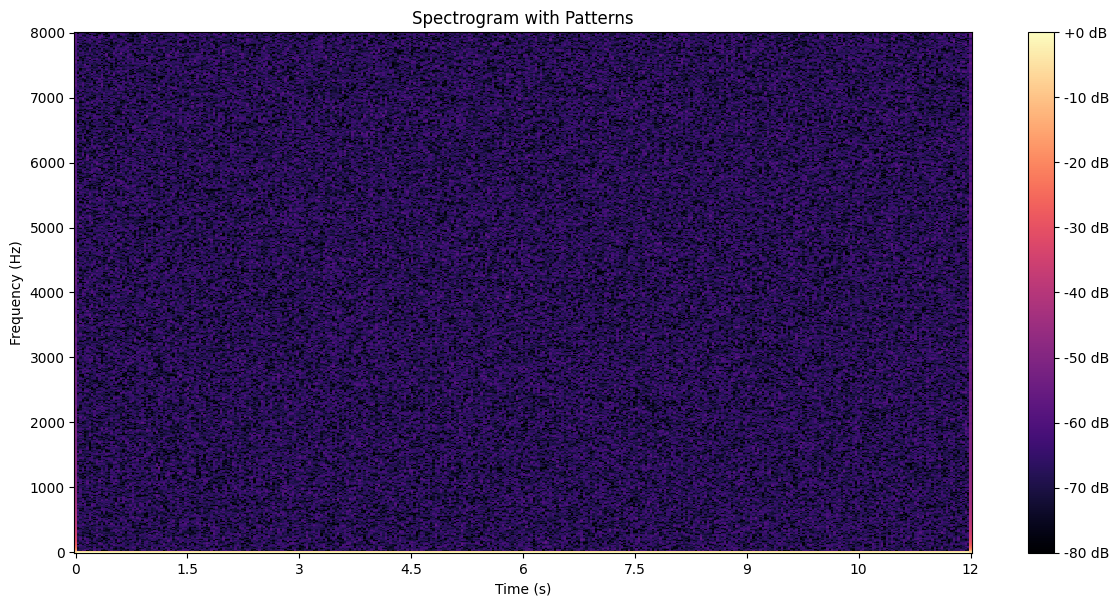

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt


class SpectrogramModifier:
    def __init__(self, sample_rate=16000, n_fft=256, hop_length=None, 
                 noise_strength=0.1, noise_type='gaussian', noise_params=None):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length if hop_length is not None else n_fft // 4
        self.noise_strength = noise_strength
        self.noise_type = noise_type
        self.noise_params = noise_params if noise_params else {}
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None

    def _get_freqs(self):
        return np.linspace(0, self.sample_rate / 2, self.S_db.shape[0])

    def _get_times(self):
        return librosa.frames_to_time(np.arange(self.S_db.shape[1]), sr=self.sample_rate, hop_length=self.hop_length)

    def _get_distribution(self, values, distribution, params):
        if distribution == 'gaussian':
            sigma = params.get('sigma', 5)
            center = (values.min() + values.max()) / 2
            dist = np.exp(-0.5 * ((values - center) / sigma) ** 2)
        elif distribution == 'uniform':
            dist = np.ones_like(values)
        elif distribution == 'exponential':
            scale = params.get('scale', 1.0)
            dist = np.exp(-values / scale)
        else:
            raise ValueError("Unsupported distribution type.")
        dist /= dist.max()  # Normalize
        return dist

    def _select_random_or_linear_indices(self, indices, n, mode):
        if mode == 'linear':
            selected_indices = np.linspace(indices.min(), indices.max(), num=n, dtype=int)
            selected_indices = selected_indices[selected_indices < len(indices)]
        elif mode == 'random':
            if n > len(indices):
                n = len(indices)
            selected_indices = np.random.choice(indices, size=n, replace=False)
        else:
            raise ValueError("Unsupported mode type.")
        return selected_indices

    def add_spectral_pattern(self, pattern_params, intensity_factor=1.0):
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")

        S_db_modified = self.S_db.copy()
        freqs = self._get_freqs()
        times = self._get_times()

        for pattern in pattern_params:
            pattern_type = pattern['pattern_type']
            mode = pattern.get('mode', 'linear')
            strength_dB = pattern['strength_dB'] * intensity_factor
            distribution = pattern.get('distribution', 'uniform')
            dist_params = pattern.get('distribution_params', {})

            if pattern_type == 'horizontal':  # Frequency-based (horizontal)
                freq_min = pattern['freq_min']
                freq_max = pattern['freq_max']
                freq_indices = np.where((freqs >= freq_min) & (freqs <= freq_max))[0]

                if mode == 'range':  # Range-based
                    energy_distribution = self._get_distribution(freqs[freq_indices], distribution, dist_params)
                    S_db_modified[freq_indices, :] += strength_dB * energy_distribution[:, np.newaxis]
                elif mode == 'stripe':  # Random/linear patterns
                    n = pattern.get('n', 10)
                    selected_indices = self._select_random_or_linear_indices(freq_indices, n, mode)
                    S_db_modified[selected_indices, :] += strength_dB

            elif pattern_type == 'vertical':  # Time-based (vertical)
                time_min = pattern['time_min']
                time_max = pattern['time_max']
                time_indices = np.where((times >= time_min) & (times <= time_max))[0]

                if mode == 'range':  # Range-based
                    energy_distribution = self._get_distribution(times[time_indices], distribution, dist_params)
                    S_db_modified[:, time_indices] += strength_dB * energy_distribution[np.newaxis, :]
                elif mode == 'stripe':  # Random/linear patterns
                    n = pattern.get('n', 10)
                    selected_indices = self._select_random_or_linear_indices(time_indices, n, mode)
                    S_db_modified[:, selected_indices] += strength_dB

        self.S_db = S_db_modified
        return self.S_db

    def compute_spectrogram(self, signal):
        self.signal = signal
        S = np.abs(librosa.stft(signal, n_fft=self.n_fft, hop_length=self.hop_length, window='hann'))
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram'):
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0.5)
        return fig, ax


sample_rate = 16000
duration = 12
n_samples = sample_rate * duration
signal = np.random.normal(-80, 1, n_samples)

spectro_mod = SpectrogramModifier(
    sample_rate=sample_rate,
    n_fft=1024,
    hop_length=512
)
S_db = spectro_mod.compute_spectrogram(signal)


pattern_params = [
    {'pattern_type': 'horizontal', 'mode': 'linear', 'freq_min': 300, 'freq_max': 400, 
     'strength_dB': 30, 'distribution': 'gaussian', 'distribution_params': {'sigma': 50}},
    {'pattern_type': 'horizontal', 'mode': 'random', 'freq_min': 500, 'freq_max': 5000, 
     'strength_dB': 400, 'n': 50},
    {'pattern_type': 'vertical', 'mode': 'linear', 'time_min': 2, 'time_max': 4, 
     'strength_dB': -15, 'distribution': 'exponential', 'distribution_params': {'scale': 0.2}},
    {'pattern_type': 'vertical', 'mode': 'random', 'time_min': 1, 'time_max': 3, 
     'strength_dB': 20, 'n': 5}
]

spectro_mod.add_spectral_pattern(pattern_params)


fig, ax = spectro_mod.plot_spectrogram(
    show_labels=True,
    colormap='magma',
    title='Spectrogram with Patterns'
)
plt.show()
